In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""flags, file path, and file names for saving data and figures"""

# load simualted data generated for fig. 2 from this path (including file name)
data_path = 'YOUR LOCAL DIRECTORY WHERE DATA FILE IS ALREADY SAVED'

# save figure panel(s) to this path (exluding file name)
save2path = 'YOUR LOCAL DIRECTORY FOR SAVING FILES'

# save figure panel 3d?
save_fig3d_randomized_trials = False
# save figure panel 3f?
save_fig3f_randomized_trials = False
# figure panel file format, e.g. 'pdf', 'eps', 'svg'
fig_format = 'pdf'
# figure panel file names
filename_fig3d = 'fig3d-individual-variation_yyyy-mm-dd'
filename_fig3f = 'fig3f-individual-variation_yyyy-mm-dd'

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
from ra_network import RingAttractorNetwork, \
    back_to_circ, movmean, plot_all, sliding_window, offset_variation, \
        generate_ground_truth, generate_ER_input, generate_AV_input_noise, generate_ER_input_noise

In [4]:
# plotting parameters

mpl.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
    })

%matplotlib inline

In [5]:
# ring attractor network parameters

network_params = {
    'N' : 32,                               # number of neurons
    'tau': 0.05,                            # network time constant [s]
    'alpha': -8.93,                         # self-excitation parameter
    'D' : 5.19,                             # nearest-neighbor excitation
    'beta' : 0.11,                          # global inhibition parameter
    'f_act' : lambda x: np.maximum(0,x+1),  # activation function
    'v_rel' : 3.64 ,                        # angular velocity conversion factor
    'dt' : 0.0025                           # step size [s]
    }

In [6]:
"""load data arrays"""

with np.load(data_path) as data_arrays:
    offset_variability_array = data_arrays['offset_variability_array']      # np.ndarray (n_sims, n_ER_amplitudes)
    HD_encoding_accuracy_array = data_arrays['HD_encoding_accuracy_array']  # np.ndarray (n_sims, n_ER_amplitudes)
    bump_width_array = data_arrays['bump_width_array']                      # np.ndarray (n_sims, n_ER_amplitudes)
    bump_amplitude_array = data_arrays['bump_amplitude_array']              # np.ndarray (n_sims, n_ER_amplitudes)
    W_notch_depth_array = data_arrays['W_notch_depth_array']                # np.ndarray (n_sims, n_ER_amplitudes)
    ER_amplitude_array = data_arrays['ER_amplitude_array']                  # np.ndarray (n_ER_amplitudes,)

In [7]:
# specify parameters
n_flies = 15                                    # number of flies in experiment
n_subsamples = int(1e8)                         # number of subsamples for analyzing strength and significance of correlation
n_trials = 5                                    # number of trials per individual (ER amplitude)
idx_individuals = np.arange(10, 21, 1)          # indices for ER amplitude array corresponding to different individuals

# get relevant number from data arrays
n_sims = HD_encoding_accuracy_array.shape[0]                            # total number of simulation runs in dataset
n_ER_amplitudes = len(ER_amplitude_array)                               # total number of ER amplitudes in dataset
n_individuals = len(idx_individuals)                                    # number of individuals
individual_ER_amplitude_array = ER_amplitude_array[idx_individuals]     # array of ER amplitudes corresponding to different individuals

In [8]:
"""sample simulation runs, i.e. trials, independently for each individual"""

# initialize arrays for storage
HD_encoding_accuracy_samples = np.full((n_trials, n_individuals), np.nan)
bump_width_samples = np.full((n_trials, n_individuals), np.nan)
bump_amplitude_samples = np.full((n_trials, n_individuals), np.nan)
idx_trials_array = np.full((n_individuals, n_trials), np.nan)

for i_individual in range(n_individuals):
    # generate indices of sample trials for each individual
    idx_trials = random.sample(range(n_sims), n_trials)
    idx_trials_array[i_individual] = idx_trials
    # idx_trials = idx_trials_array[i_individual].astype(int)
    idx_individual = np.repeat(idx_individuals[i_individual], n_trials)
    
    # sample
    HD_encoding_accuracy_samples[:, i_individual] = HD_encoding_accuracy_array[idx_trials, idx_individual]
    bump_width_samples[:, i_individual] = bump_width_array[idx_trials, idx_individual]
    bump_amplitude_samples[:, i_individual] = bump_amplitude_array[idx_trials, idx_individual]

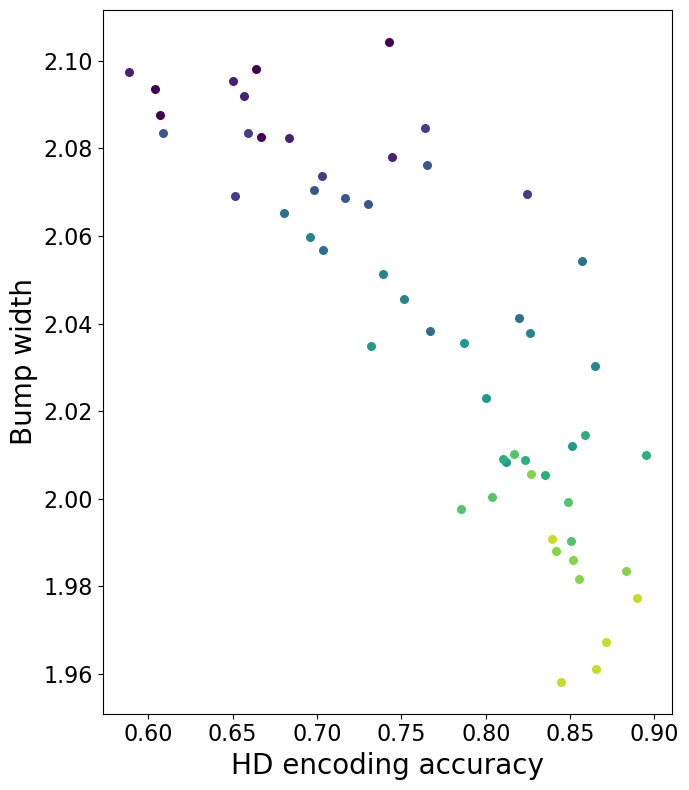

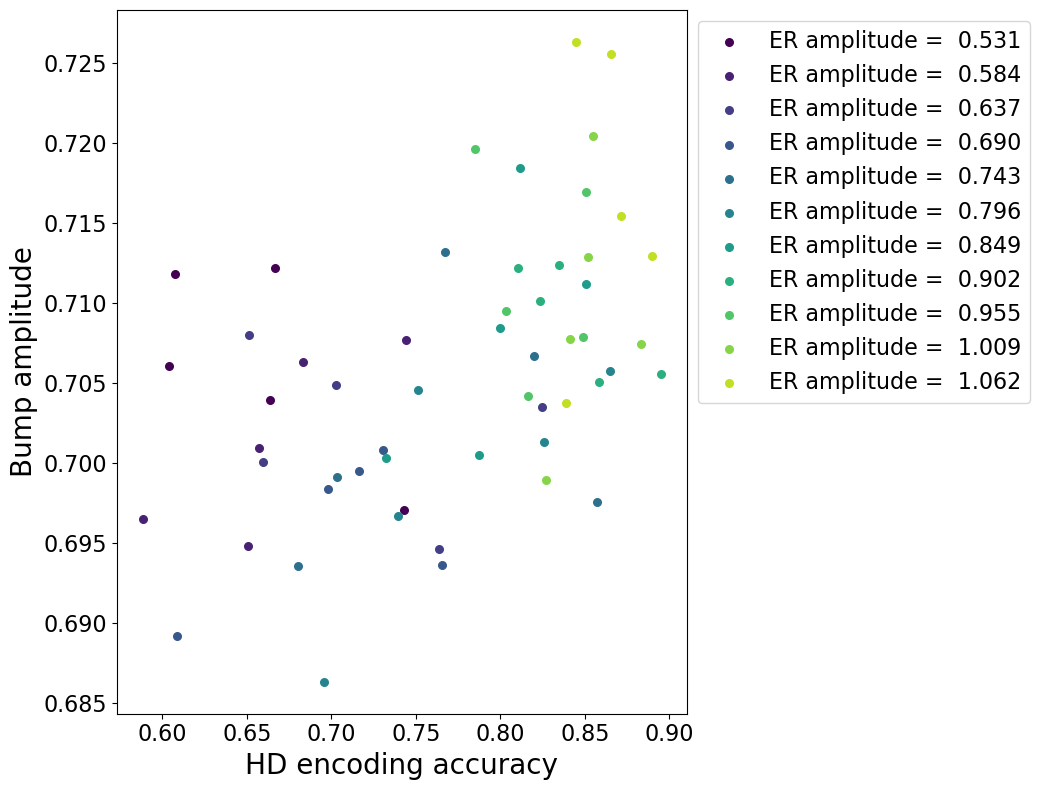

In [9]:
"""visualization"""

plot_fig3d_randomized_trials = True
plot_fig3f_randomized_trials = True

x_axis = np.linspace(np.amin(HD_encoding_accuracy_samples), np.amax(HD_encoding_accuracy_samples))

if plot_fig3d_randomized_trials:
    fig3d_randomized_trials, ax3d_randomized_trials = plt.subplots(1, 1, figsize=(7, 8))

    for i_individual, ER_amplitude in enumerate(individual_ER_amplitude_array):
        color = plt.cm.viridis(i_individual / n_individuals)
        ax3d_randomized_trials.scatter(
            HD_encoding_accuracy_samples[:, i_individual], bump_width_samples[:, i_individual], 
            color=color, s=30
        )

    """fit linear regression and uncomment code below to show linear fit"""
    linfit_fig3d = stats.linregress(HD_encoding_accuracy_samples.flatten(), bump_width_samples.flatten())
    # ax3d_randomized_trials.plot(
    #     x_axis, x_axis * linfit_fig3d.slope + linfit_fig3d.intercept, 'k', linewidth=1,
    #     label=f'slope = {linfit_fig3d.slope : .03f}\n$R^2 = {linfit_fig3d.rvalue**2 : .03f}$\n$p = {linfit_fig3d.pvalue : .03e}$'
    # )
    # ax3d_randomized_trials.legend(loc='best')

    ax3d_randomized_trials.set_xlabel('HD encoding accuracy')
    ax3d_randomized_trials.set_ylabel('Bump width')

    plt.tight_layout()

if plot_fig3f_randomized_trials:
    fig3f_randomized_trials, ax3f_randomized_trials = plt.subplots(1, 1, figsize=(10.5, 8))

    for i_individual, ER_amplitude in enumerate(individual_ER_amplitude_array):
        color = plt.cm.viridis(i_individual / n_individuals)
        ax3f_randomized_trials.scatter(
            HD_encoding_accuracy_samples[:, i_individual], bump_amplitude_samples[:, i_individual], 
            color=color, s=30, label=f'ER amplitude = {ER_amplitude : .03f}'
        )

    """fit linear regression and uncomment code below to show linear fit"""
    linfit_fig3f = stats.linregress(HD_encoding_accuracy_samples.flatten(), bump_amplitude_samples.flatten())
    # ax3f_randomized_trials.plot(
    #     x_axis, x_axis * linfit_fig3f.slope + linfit_fig3f.intercept, 'k', linewidth=1,
    #     label=f'slope = {linfit_fig3f.slope : .03f}\n$R^2 = {linfit_fig3f.rvalue**2 : .03f}$\n$p = {linfit_fig3f.pvalue : .03e}$'
    # )

    ax3f_randomized_trials.set_xlabel('HD encoding accuracy')
    ax3f_randomized_trials.set_ylabel('Bump amplitude')

    ax3f_randomized_trials.legend(bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()

In [10]:
"""save figure panels"""

if save_fig3d_randomized_trials:
    fig3d_randomized_trials.savefig(os.path.join(save2path, filename_fig3d + '.' + fig_format), format=fig_format)

if save_fig3f_randomized_trials:
    fig3f_randomized_trials.savefig(os.path.join(save2path, filename_fig3f + '.' + fig_format), format=fig_format)

In [11]:
"""subsampling analysis"""

# run subsampling analysis?
run_subsampling_analysis = False

if run_subsampling_analysis:
    # initialize arrays
    # 1st col: slope
    # 2nd col: intercept
    # 3rd col: Pearson's R
    # 4th col: p-value
    subsample_linregress_bump_width_vs_HD_encoding_accuracy = np.full((n_subsamples, 4), np.nan)
    subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy = np.full((n_subsamples, 4), np.nan)
    idx_flies_array = np.full((n_subsamples, n_flies), np.nan)

    # flatten arrays
    # treat every trial (total: n_trials) and every ER amplitude (total: n_individuals) as an individual fly (total: n_trials * n_individuals)
    HD_encoding_accuracy_samples_flattened = HD_encoding_accuracy_samples.flatten()             # np.ndarray (n_trials * n_individuals,)
    bump_width_samples_flattened = bump_width_samples.flatten()                                 # np.ndarray (n_trials * n_individuals,)
    bump_amplitude_samples_flattened = bump_amplitude_samples.flatten()                         # np.ndarray (n_trials * n_individuals,)

    for i_subsample in tqdm(range(n_subsamples)):
        # subsample simulated data (size of each subsample: n_flies)
        idx_flies = random.sample(range(n_trials * n_individuals), n_flies)
        idx_flies_array[i_subsample] = idx_flies
        HD_encoding_accuracy_subsample = HD_encoding_accuracy_samples_flattened[idx_flies]      # np.ndarray (n_flies,)
        bump_width_subsample = bump_width_samples_flattened[idx_flies]                          # np.ndarray (n_flies,)
        bump_amplitude_subsample = bump_amplitude_samples_flattened[idx_flies]                  # np.ndarray (n_flies,)

        # run linear regression on subsample of simulated data
        subsample_linregress_width = stats.linregress(HD_encoding_accuracy_subsample, bump_width_subsample)
        subsample_linregress_amplitude = stats.linregress(HD_encoding_accuracy_subsample, bump_amplitude_subsample)

        # store statistics
        subsample_linregress_bump_width_vs_HD_encoding_accuracy[i_subsample, 0] = subsample_linregress_width.slope
        subsample_linregress_bump_width_vs_HD_encoding_accuracy[i_subsample, 1] = subsample_linregress_width.intercept
        subsample_linregress_bump_width_vs_HD_encoding_accuracy[i_subsample, 2] = subsample_linregress_width.rvalue
        subsample_linregress_bump_width_vs_HD_encoding_accuracy[i_subsample, 3] = subsample_linregress_width.pvalue

        subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[i_subsample, 0] = subsample_linregress_amplitude.slope
        subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[i_subsample, 1] = subsample_linregress_amplitude.intercept
        subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[i_subsample, 2] = subsample_linregress_amplitude.rvalue
        subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[i_subsample, 3] = subsample_linregress_amplitude.pvalue

In [12]:
"""subsampling analysis - fraction of p-values that are significant"""

if run_subsampling_analysis:

    # specify alpha / significance level
    alpha_significance_level = 0.05

    # average over subsamples
    avg_subsample_linregress_bump_width_vs_HD_encoding_accuracy = np.mean(
        subsample_linregress_bump_width_vs_HD_encoding_accuracy, axis=0
    )
    avg_subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy = np.mean(
        subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy, axis=0
    )

    # get p-value for each subsample
    pvalues_bump_width = subsample_linregress_bump_width_vs_HD_encoding_accuracy[:, 3]
    pvalues_bump_amplitude = subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[:, 3]

    # compute fraction of p-values that are significant
    fraction_significant_pvalue_bump_width = pvalues_bump_width < alpha_significance_level
    fraction_significant_pvalue_bump_amplitude = pvalues_bump_amplitude < alpha_significance_level
    fraction_significant_pvalue_bump_width = np.sum(fraction_significant_pvalue_bump_width) / np.shape(fraction_significant_pvalue_bump_width)[0]
    fraction_significant_pvalue_bump_amplitude = np.sum(fraction_significant_pvalue_bump_amplitude) / np.shape(fraction_significant_pvalue_bump_amplitude)[0]

    # output results of subsampling analysis
    print(f'{HD_encoding_accuracy_samples.size} data points; \
    {n_subsamples} subsamples; \
    each subsample contains {n_flies} data points (same n as experiment)'
    )

    print(
        f'Bump width vs. HD encoding accuracy\naveraged over {n_subsamples} subsamples\n\
        slope = {avg_subsample_linregress_bump_width_vs_HD_encoding_accuracy[0] : .03f}\n\
        intercept = {avg_subsample_linregress_bump_width_vs_HD_encoding_accuracy[1] : .03f}\n\
        Pearson\'s r = {avg_subsample_linregress_bump_width_vs_HD_encoding_accuracy[2] : .03f}\n\
        p-value = {avg_subsample_linregress_bump_width_vs_HD_encoding_accuracy[3] : .03e}\n\
        fraction of p-values below 0.05: {fraction_significant_pvalue_bump_width * 100: .04f}%'
    )

    print(
        f'Bump amplitude vs. HD encoding accuracy\naveraged over {n_subsamples} subsamples\n\
        slope = {avg_subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[0] : .03f}\n\
        intercept = {avg_subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[1] : .03f}\n\
        Pearson\'s r = {avg_subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[2] : .03f}\n\
        p-value = {avg_subsample_linregress_bump_amplitude_vs_HD_encoding_accuracy[3] : .03e}\n\
        fraction of p-values below 0.05: {fraction_significant_pvalue_bump_amplitude * 100 : .04f}%'
    )